In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import os
from PIL import Image
from tqdm import tqdm
from glob import glob


import tensorflow as tf
from tensorflow.keras.layers import Conv2D , MaxPooling2D , BatchNormalization , Conv2DTranspose , Concatenate ,  Input
from tensorflow.keras.models import Sequential , Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import warnings
warnings.filterwarnings('ignore')

2025-09-20 12:20:46.701694: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758370846.929545      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758370846.997263      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [40]:
target="/kaggle/input/datasegmenation/data"
images = "/kaggle/input/datasegmenation/data/images" 
labels = "/kaggle/input/datasegmenation/data/labels"

In [64]:
def count_image(directory) :  
    categories = os.listdir(directory)
    category_count = {
        category : len(os.listdir(os.path.join(directory , category))) for category in categories
    }
    return category_count 

In [45]:
images_count = count_image(target) 
print(f"the images count : {images_count}")
print("-----------------------")
labels_count = count_image(target) 
print(f"the labels count : {labels_count}") 

the images count : {'labels': 456, 'images': 306}
-----------------------
the labels count : {'labels': 456, 'images': 306}


In [76]:
import os
import numpy as np
import tifffile
import cv2
from glob import glob


images_path = "/kaggle/input/datasegmenation/data/images/"
masks_path  = "/kaggle/input/datasegmenation/data/labels/"


image_files = sorted(glob(os.path.join(images_path, "*.tif")))
mask_files  = sorted(glob(os.path.join(masks_path, "*.png")))

print("Total images:", len(image_files))
print("Total masks:", len(mask_files))

X = []
Y = []

for img_file in image_files:
  
    img = tifffile.imread(img_file)  # shape = (H, W, 12)
    
   
    if img.ndim == 3 and img.shape[-1] >= 3:
        img = img[..., :3]  
    else:
        img = img[..., np.newaxis]  
    
    
    img = img.astype(np.float32)
    img = img / 255.0
    
   
    base_name = os.path.splitext(os.path.basename(img_file))[0]
    
   
    mask_file = os.path.join(masks_path, base_name + ".png")
    
    if not os.path.exists(mask_file):
        print(f"[Warning] No mask found for {base_name}, skipped.")
        continue
    
    mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (img.shape[1], img.shape[0]))
    
   
    mask = (mask > 127).astype(np.uint8)
    mask = np.expand_dims(mask, axis=-1)  
    
    
    X.append(img)
    Y.append(mask)


X = np.array(X)
Y = np.array(Y)

print("Final Images shape:", X.shape)
print("Final Masks shape:", Y.shape)


Total images: 306
Total masks: 456
Final Images shape: (306, 128, 128, 3)
Final Masks shape: (306, 128, 128, 1)


In [79]:
#  from sklearn.model_selection import train_test_split

# X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


In [82]:
import tensorflow as tf
from tensorflow.keras import layers, models


def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

   
    c1 = layers.Conv2D(64, (3,3), activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(64, (3,3), activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(128, (3,3), activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, (3,3), activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(256, (3,3), activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(256, (3,3), activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    c4 = layers.Conv2D(512, (3,3), activation="relu", padding="same")(p3)
    c4 = layers.Conv2D(512, (3,3), activation="relu", padding="same")(c4)
    p4 = layers.MaxPooling2D((2,2))(c4)

   
    c5 = layers.Conv2D(1024, (3,3), activation="relu", padding="same")(p4)
    c5 = layers.Conv2D(1024, (3,3), activation="relu", padding="same")(c5)

   
    u6 = layers.Conv2DTranspose(512, (2,2), strides=(2,2), padding="same")(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3,3), activation="relu", padding="same")(u6)
    c6 = layers.Conv2D(512, (3,3), activation="relu", padding="same")(c6)

    u7 = layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding="same")(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3,3), activation="relu", padding="same")(u7)
    c7 = layers.Conv2D(256, (3,3), activation="relu", padding="same")(c7)

    u8 = layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3,3), activation="relu", padding="same")(u8)
    c8 = layers.Conv2D(128, (3,3), activation="relu", padding="same")(c8)

    u9 = layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3,3), activation="relu", padding="same")(u9)
    c9 = layers.Conv2D(64, (3,3), activation="relu", padding="same")(c9)

   
    outputs = layers.Conv2D(1, (1,1), activation="sigmoid")(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model


input_shape = (128, 128, X.shape[-1])  # height, width, channels (3 or 12)
model = unet_model(input_shape)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


import cv2

X_resized = np.array([cv2.resize(img, (128, 128)) for img in X])
Y_resized = np.array([cv2.resize(mask, (128, 128)) for mask in Y])

print("X_resized:", X_resized.shape)
print("Y_resized:", Y_resized.shape)



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_11[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_13[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_15[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 16,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_4[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_17[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 8, 8, 512) │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_5[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ conv2d_19[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_20[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

X_resized: (306, 128, 128, 3)
Y_resized: (306, 128, 128)


In [83]:
history = model.fit(
    X_resized, Y_resized,
    batch_size=8,
    epochs=20,
    validation_split=0.2
)


Epoch 1/20


I0000 00:00:1758378073.300158     146 service.cc:148] XLA service 0x7c9e5c00ddf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758378073.300866     146 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758378073.300887     146 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758378074.301184     146 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758378094.508859     146 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9995 - loss: 0.1074

E0000 00:00:1758378104.595495     147 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758378104.813983     147 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


31/31 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9995 - loss: 0.1024 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 1.1921e-07 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 1.1921e-07 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 1.1921e-07 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 1.1921e-07 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 1.1921e-07 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.1921e-07 - val_accuracy: 1.0000 - val_loss: 1.1921e-07
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1

In [84]:

loss, acc = model.evaluate(X_resized, Y_resized)
print(f"Validation Loss: {loss:.4f}, Accuracy: {acc:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 1.0000 - loss: 1.1921e-07 
Validation Loss: 0.0000, Accuracy: 1.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


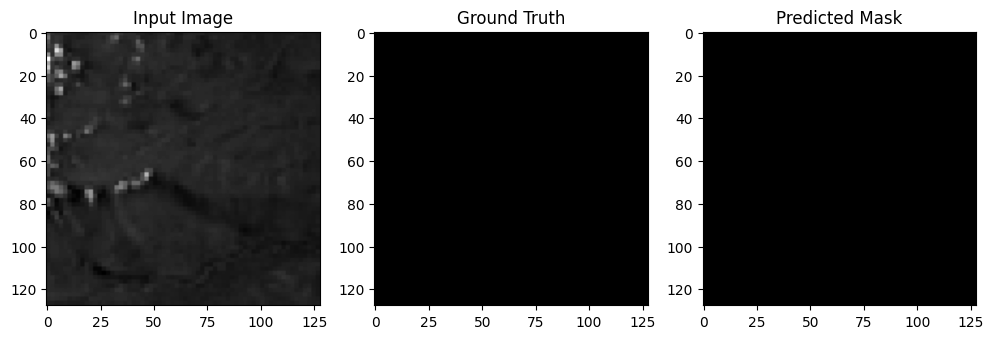

In [85]:
import matplotlib.pyplot as plt


idx = 10
test_img = X_resized[idx]
test_mask = Y_resized[idx]


pred_mask = model.predict(np.expand_dims(test_img, axis=0))[0]

pred_mask = (pred_mask > 0.5).astype(np.uint8)


plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(test_img[:,:,0] if test_img.shape[-1] > 1 else test_img.squeeze(), cmap="gray")
plt.title("Input Image")

plt.subplot(1,3,2)
plt.imshow(test_mask.squeeze(), cmap="gray")
plt.title("Ground Truth")

plt.subplot(1,3,3)
plt.imshow(pred_mask.squeeze(), cmap="gray")
plt.title("Predicted Mask")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


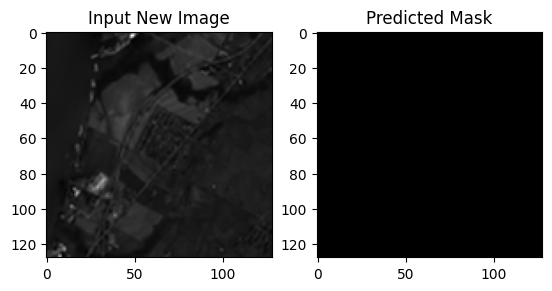

In [86]:

new_img_path = "/kaggle/input/datasegmenation/data/images/170.tif"

import tifffile
new_img = tifffile.imread(new_img_path)


new_img_resized = cv2.resize(new_img, (128, 128))
new_img_resized = new_img_resized / 255.0  # normalize


pred_new = model.predict(np.expand_dims(new_img_resized, axis=0))[0]
pred_new = (pred_new > 0.5).astype(np.uint8)

plt.subplot(1,2,1)
plt.imshow(new_img_resized[:,:,0] if new_img_resized.shape[-1] > 1 else new_img_resized, cmap="gray")
plt.title("Input New Image")

plt.subplot(1,2,2)
plt.imshow(pred_new.squeeze(), cmap="gray")
plt.title("Predicted Mask")

plt.show()


In [87]:

model.save("segmentation_unet.h5")
print(" Model saved")


 Model saved
